In [3]:
#PRACTICUM DANIEL BETANCOURT
#MODEL 2. PREDICT IF A LOAN WILL HAVE BAD PAYMENTS

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

print("import ok")


import ok


In [4]:
# read loans dataset
df = pd.read_csv('loans_data.csv', sep=';')
df.head()

,loan_yy,loan_mm,loan_dd,amount,duration,birth_yy,birth_mm,birth_dd,gender,district_id,...,ratio_urban,avg_salary,unemploy_95,unemploy_96,dif_unemp,entrep,crimes_95,crimes_96,dif_crimes,response
0,94,1,5,80952,24,45,2,4,1,1,...,1000,12541,0.29,0.43,0.14,167,85677,99107,13430,1
1,96,4,29,30276,12,39,4,23,0,21,...,670,9104,1.51,2.07,0.56,123,2299,2354,55,0
2,97,12,8,30276,12,62,2,9,1,68,...,572,9893,4.09,4.72,0.63,96,5623,5887,264,1
3,98,10,14,318480,60,52,8,26,1,20,...,584,8547,2.65,3.64,0.99,120,1563,1542,-21,0
4,98,4,19,110736,48,40,1,30,0,19,...,527,8402,3.13,3.98,0.85,120,999,1099,100,1


In [5]:
df.count()

loan_yy        682
loan_mm        682
loan_dd        682
amount         682
duration       682
birth_yy       682
birth_mm       682
birth_dd       682
gender         682
district_id    682
inhabitants    682
cities         682
ratio_urban    682
avg_salary     682
unemploy_95    682
unemploy_96    682
dif_unemp      682
entrep         682
crimes_95      682
crimes_96      682
dif_crimes     682
response       682
dtype: int64

In [6]:
df.describe()

,loan_yy,loan_mm,loan_dd,amount,duration,birth_yy,birth_mm,birth_dd,gender,district_id,...,ratio_urban,avg_salary,unemploy_95,unemploy_96,dif_unemp,entrep,crimes_95,crimes_96,dif_crimes,response
count,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,...,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.00000,682.000000,682.000000,682.000000
mean,96.234604,6.664223,15.447214,151410.175953,36.492669,58.098240,6.520528,16.019062,0.489736,38.043988,...,678.639296,9469.230205,2.953959,3.551598,0.597522,120.585044,14065.35044,15651.299120,1585.948680,0.888563
std,1.466445,3.443717,9.116524,113372.406310,17.075219,12.688891,3.506280,8.833153,0.500262,25.029929,...,200.908916,1301.835849,1.899225,2.140448,0.388405,23.004614,26277.80217,30510.152293,4299.055045,0.314903
min,93.000000,1.000000,1.000000,4980.000000,12.000000,35.000000,1.000000,1.000000,0.000000,1.000000,...,339.000000,8110.000000,0.290000,0.430000,-0.360000,81.000000,818.00000,888.000000,-974.000000,0.000000
25%,95.000000,4.000000,8.000000,66732.000000,24.000000,47.000000,3.250000,8.000000,0.000000,14.000000,...,520.000000,8544.000000,1.600000,1.960000,0.290000,106.000000,2159.00000,2265.250000,-71.500000,1.000000
50%,97.000000,7.000000,15.000000,116928.000000,36.000000,58.000000,7.000000,16.000000,0.000000,40.000000,...,620.000000,8980.000000,2.790000,3.490000,0.580000,115.000000,3659.00000,3651.000000,98.000000,1.000000
75%,97.000000,10.000000,24.000000,210654.000000,48.000000,69.000000,10.000000,24.000000,1.000000,60.000000,...,855.000000,9897.000000,4.010000,4.790000,0.850000,132.000000,6604.00000,6295.000000,278.000000,1.000000
max,98.000000,12.000000,31.000000,590820.000000,60.000000,80.000000,12.000000,31.000000,1.000000,77.000000,...,1000.000000,12541.000000,7.340000,9.400000,2.060000,167.000000,85677.00000,99107.000000,13430.000000,1.000000


In [7]:
#check nulls
df.isnull().sum().max()

0

In [9]:
# check imbalance good payments, bad payments
print('Good', round(df['response'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Bad', round(df['response'].value_counts()[0]/len(df) * 100,2), '% of the dataset')

Good 88.86 % of the dataset
Bad 11.14 % of the dataset


Text(0.5, 1.0, 'Credit \n (0: Bad || 1: Good)')

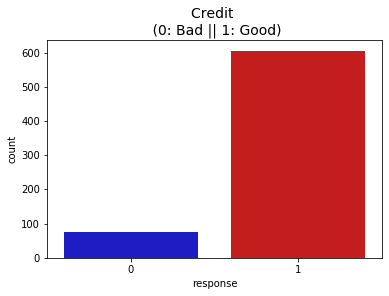

In [10]:
#plot imbalance
import seaborn as sns
colors = ["#0101DF", "#DF0101"]
sns.countplot('response', data=df, palette=colors)
plt.title('Credit \n (0: Bad || 1: Good)', fontsize=14)

In [11]:
# scale data
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()
df['s_loan_yy'] = rob_scaler.fit_transform(df['loan_yy'].values.reshape(-1,1))
df['s_loan_mm'] = rob_scaler.fit_transform(df['loan_mm'].values.reshape(-1,1))
df['s_loan_dd'] = rob_scaler.fit_transform(df['loan_dd'].values.reshape(-1,1))
df['s_amount'] = rob_scaler.fit_transform(df['amount'].values.reshape(-1,1))
df['s_duration'] = rob_scaler.fit_transform(df['duration'].values.reshape(-1,1))
df['s_birth_yy'] = rob_scaler.fit_transform(df['birth_yy'].values.reshape(-1,1))
df['s_birth_mm'] = rob_scaler.fit_transform(df['birth_mm'].values.reshape(-1,1))
df['s_birth_dd'] = rob_scaler.fit_transform(df['birth_dd'].values.reshape(-1,1))
df['s_gender'] = rob_scaler.fit_transform(df['gender'].values.reshape(-1,1))
df['s_district_id'] = rob_scaler.fit_transform(df['district_id'].values.reshape(-1,1))
df['s_inhabitants'] = rob_scaler.fit_transform(df['inhabitants'].values.reshape(-1,1))
df['s_cities'] = rob_scaler.fit_transform(df['cities'].values.reshape(-1,1))
df['s_ratio_urban'] = rob_scaler.fit_transform(df['ratio_urban'].values.reshape(-1,1))
df['s_avg_salary'] = rob_scaler.fit_transform(df['avg_salary'].values.reshape(-1,1))
df['s_unemploy_95'] = rob_scaler.fit_transform(df['unemploy_95'].values.reshape(-1,1))
df['s_unemploy_96'] = rob_scaler.fit_transform(df['unemploy_96'].values.reshape(-1,1))
df['s_dif_unemp'] = rob_scaler.fit_transform(df['dif_unemp'].values.reshape(-1,1))
df['s_entrep'] = rob_scaler.fit_transform(df['entrep'].values.reshape(-1,1))
df['s_crimes_95'] = rob_scaler.fit_transform(df['crimes_95'].values.reshape(-1,1))
df['s_crimes_96'] = rob_scaler.fit_transform(df['crimes_96'].values.reshape(-1,1))
df['s_dif_crimes'] = rob_scaler.fit_transform(df['dif_crimes'].values.reshape(-1,1))
df.head()


,loan_yy,loan_mm,loan_dd,amount,duration,birth_yy,birth_mm,birth_dd,gender,district_id,...,s_cities,s_ratio_urban,s_avg_salary,s_unemploy_95,s_unemploy_96,s_dif_unemp,s_entrep,s_crimes_95,s_crimes_96,s_dif_crimes
0,94,1,5,80952,24,45,2,4,1,1,...,-1.666667,1.134328,2.631929,-1.037344,-1.081272,-0.785714,2.000000,18.451744,23.687822,38.145923
1,96,4,29,30276,12,39,4,23,0,21,...,0.333333,0.149254,0.091648,-0.531120,-0.501767,-0.035714,0.307692,-0.305962,-0.321856,-0.123033
2,97,12,8,30276,12,62,2,9,1,68,...,0.000000,-0.143284,0.674797,0.539419,0.434629,0.089286,-0.730769,0.441845,0.554873,0.474964
3,98,10,14,318480,60,52,8,26,1,20,...,-0.666667,-0.107463,-0.320030,-0.058091,0.053004,0.732143,0.192308,-0.471541,-0.523358,-0.340486
4,98,4,19,110736,48,40,1,30,0,19,...,-0.666667,-0.277612,-0.427199,0.141079,0.173145,0.482143,0.192308,-0.598425,-0.633290,0.005722


In [12]:
# drop original columns
df.drop(['loan_yy', 'loan_mm', 'loan_dd', 'amount', 'duration', 'birth_yy',
       'birth_mm', 'birth_dd', 'gender', 'district_id', 'inhabitants',
       'cities', 'ratio_urban', 'avg_salary', 'unemploy_95', 'unemploy_96', 'dif_unemp',
       'entrep', 'crimes_95', 'crimes_96', 'dif_crimes'], axis=1, inplace=True)
df.head()

,response,s_loan_yy,s_loan_mm,s_loan_dd,s_amount,s_duration,s_birth_yy,s_birth_mm,s_birth_dd,s_gender,...,s_cities,s_ratio_urban,s_avg_salary,s_unemploy_95,s_unemploy_96,s_dif_unemp,s_entrep,s_crimes_95,s_crimes_96,s_dif_crimes
0,1,-1.5,-1.000000,-0.6250,-0.249969,-0.5,-0.590909,-0.740741,-0.7500,1.0,...,-1.666667,1.134328,2.631929,-1.037344,-1.081272,-0.785714,2.000000,18.451744,23.687822,38.145923
1,0,-0.5,-0.500000,0.8750,-0.602076,-1.0,-0.863636,-0.444444,0.4375,0.0,...,0.333333,0.149254,0.091648,-0.531120,-0.501767,-0.035714,0.307692,-0.305962,-0.321856,-0.123033
2,1,0.0,0.833333,-0.4375,-0.602076,-1.0,0.181818,-0.740741,-0.4375,1.0,...,0.000000,-0.143284,0.674797,0.539419,0.434629,0.089286,-0.730769,0.441845,0.554873,0.474964
3,0,0.5,0.500000,-0.0625,1.400425,1.0,-0.272727,0.148148,0.6250,1.0,...,-0.666667,-0.107463,-0.320030,-0.058091,0.053004,0.732143,0.192308,-0.471541,-0.523358,-0.340486
4,1,0.5,-0.500000,0.2500,-0.043023,0.5,-0.818182,-0.888889,0.8750,0.0,...,-0.666667,-0.277612,-0.427199,0.141079,0.173145,0.482143,0.192308,-0.598425,-0.633290,0.005722


In [13]:
# move response to te last column
resp = df['response']
df.drop(['response'], axis=1, inplace=True)
df.insert(21, 'response', resp)
df.head()

,s_loan_yy,s_loan_mm,s_loan_dd,s_amount,s_duration,s_birth_yy,s_birth_mm,s_birth_dd,s_gender,s_district_id,...,s_ratio_urban,s_avg_salary,s_unemploy_95,s_unemploy_96,s_dif_unemp,s_entrep,s_crimes_95,s_crimes_96,s_dif_crimes,response
0,-1.5,-1.000000,-0.6250,-0.249969,-0.5,-0.590909,-0.740741,-0.7500,1.0,-0.847826,...,1.134328,2.631929,-1.037344,-1.081272,-0.785714,2.000000,18.451744,23.687822,38.145923,1
1,-0.5,-0.500000,0.8750,-0.602076,-1.0,-0.863636,-0.444444,0.4375,0.0,-0.413043,...,0.149254,0.091648,-0.531120,-0.501767,-0.035714,0.307692,-0.305962,-0.321856,-0.123033,0
2,0.0,0.833333,-0.4375,-0.602076,-1.0,0.181818,-0.740741,-0.4375,1.0,0.608696,...,-0.143284,0.674797,0.539419,0.434629,0.089286,-0.730769,0.441845,0.554873,0.474964,1
3,0.5,0.500000,-0.0625,1.400425,1.0,-0.272727,0.148148,0.6250,1.0,-0.434783,...,-0.107463,-0.320030,-0.058091,0.053004,0.732143,0.192308,-0.471541,-0.523358,-0.340486,0
4,0.5,-0.500000,0.2500,-0.043023,0.5,-0.818182,-0.888889,0.8750,0.0,-0.456522,...,-0.277612,-0.427199,0.141079,0.173145,0.482143,0.192308,-0.598425,-0.633290,0.005722,1


In [37]:
# Split train and test original dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('Good', round(df['response'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Bad', round(df['response'].value_counts()[0]/len(df) * 100,2), '% of the dataset')

X = df.drop('response', axis=1)
y = df['response']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into arrays
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Check distribution of bad loans
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('\n')
print('Distributions of Bad and Good in test and train: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Good 88.86 % of the dataset
Bad 11.14 % of the dataset
Train: [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  19  21
  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  41  43  44
  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60  61  62  63
  64  66  68  69  70  72  73  74  75  77  78  79  80  81  82  83  84  86
  87  88  89  91  92  93  94  95  96  97  99 100 101 102 103 105 108 109
 110 111 112 113 114 115 116 117 118 119 120 122 123 124 125 126 127 128
 131 132 133 134 135 136 137 138 139 141 142 144 145 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 166 168 169 170 171
 172 173 174 175 176 177 178 179 182 183 184 185 186 187 189 190 191 192
 193 194 195 196 197 199 200 201 202 203 204 207 208 209 210 211 212 213
 214 215 216 217 219 220 221 222 223 224 225 226 227 230 231 235 236 239
 240 241 242 243 244 246 248 249 250 251 252 253 254 255 256 257 258 259
 261 263 264 265 266 267 269 270 271 272 273 274 277 278 279 2

In [38]:
print(train_counts_label)
print(len(original_ytrain))
print(test_counts_label)
print(len(original_ytest))

[ 61 485]
546
[ 15 121]
136


In [39]:
#UNDERSAMPLING
df = df.sample(frac=1)
# 76 bad payment records, 0 bad, 1 good
bad_df = df.loc[df['response'] == 0]
non_bad_df = df.loc[df['response'] == 1][:76]
normal_distributed_df = pd.concat([bad_df, non_bad_df])
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,s_loan_yy,s_loan_mm,s_loan_dd,s_amount,s_duration,s_birth_yy,s_birth_mm,s_birth_dd,s_gender,s_district_id,...,s_ratio_urban,s_avg_salary,s_unemploy_95,s_unemploy_96,s_dif_unemp,s_entrep,s_crimes_95,s_crimes_96,s_dif_crimes,response
230,-1.0,0.666667,0.8125,0.145746,-0.5,0.454545,-0.296296,-0.6250,1.0,-0.630435,...,-0.761194,0.474501,-0.970954,-1.024735,-0.785714,1.500000,-0.041395,-0.030275,-0.125894,0
410,-1.5,0.666667,-0.5625,-0.474257,0.0,-0.454545,-0.296296,-0.8750,0.0,0.326087,...,-0.838806,-0.175166,-0.377593,-0.374558,-0.053571,-0.153846,0.000000,0.060302,0.391989,1
559,0.5,0.500000,-0.6250,-0.502272,-0.5,-0.045455,-0.740741,-0.3125,1.0,0.413043,...,0.002985,-0.396157,0.186722,-0.007067,-0.625000,-0.346154,-0.239370,-0.334016,-1.110157,1
327,-0.5,0.000000,0.1875,-0.585651,0.5,-0.727273,0.444444,-0.0625,1.0,0.065217,...,0.426866,0.328899,-0.443983,-0.349823,0.357143,0.384615,0.095838,0.059557,-0.835479,1
367,-1.5,-0.166667,-0.5000,-0.205445,-0.5,0.181818,0.000000,-0.3750,1.0,-0.043478,...,-0.065672,-0.011086,1.780083,1.674912,1.017857,-0.423077,-0.226322,-0.205720,0.203147,1


In [40]:
new_df.count()

s_loan_yy        152
s_loan_mm        152
s_loan_dd        152
s_amount         152
s_duration       152
s_birth_yy       152
s_birth_mm       152
s_birth_dd       152
s_gender         152
s_district_id    152
s_inhabitants    152
s_cities         152
s_ratio_urban    152
s_avg_salary     152
s_unemploy_95    152
s_unemploy_96    152
s_dif_unemp      152
s_entrep         152
s_crimes_95      152
s_crimes_96      152
s_dif_crimes     152
response         152
dtype: int64

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: response, dtype: float64


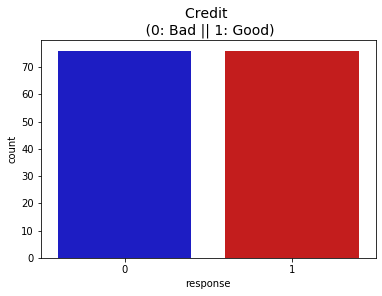

In [41]:
#plot under sampling distribution
print('Distribution of the Classes in the subsample dataset')
print(new_df['response'].value_counts()/len(new_df))
sns.countplot('response', data=new_df, palette=colors)
plt.title('Credit \n (0: Bad || 1: Good)', fontsize=14)
plt.show()

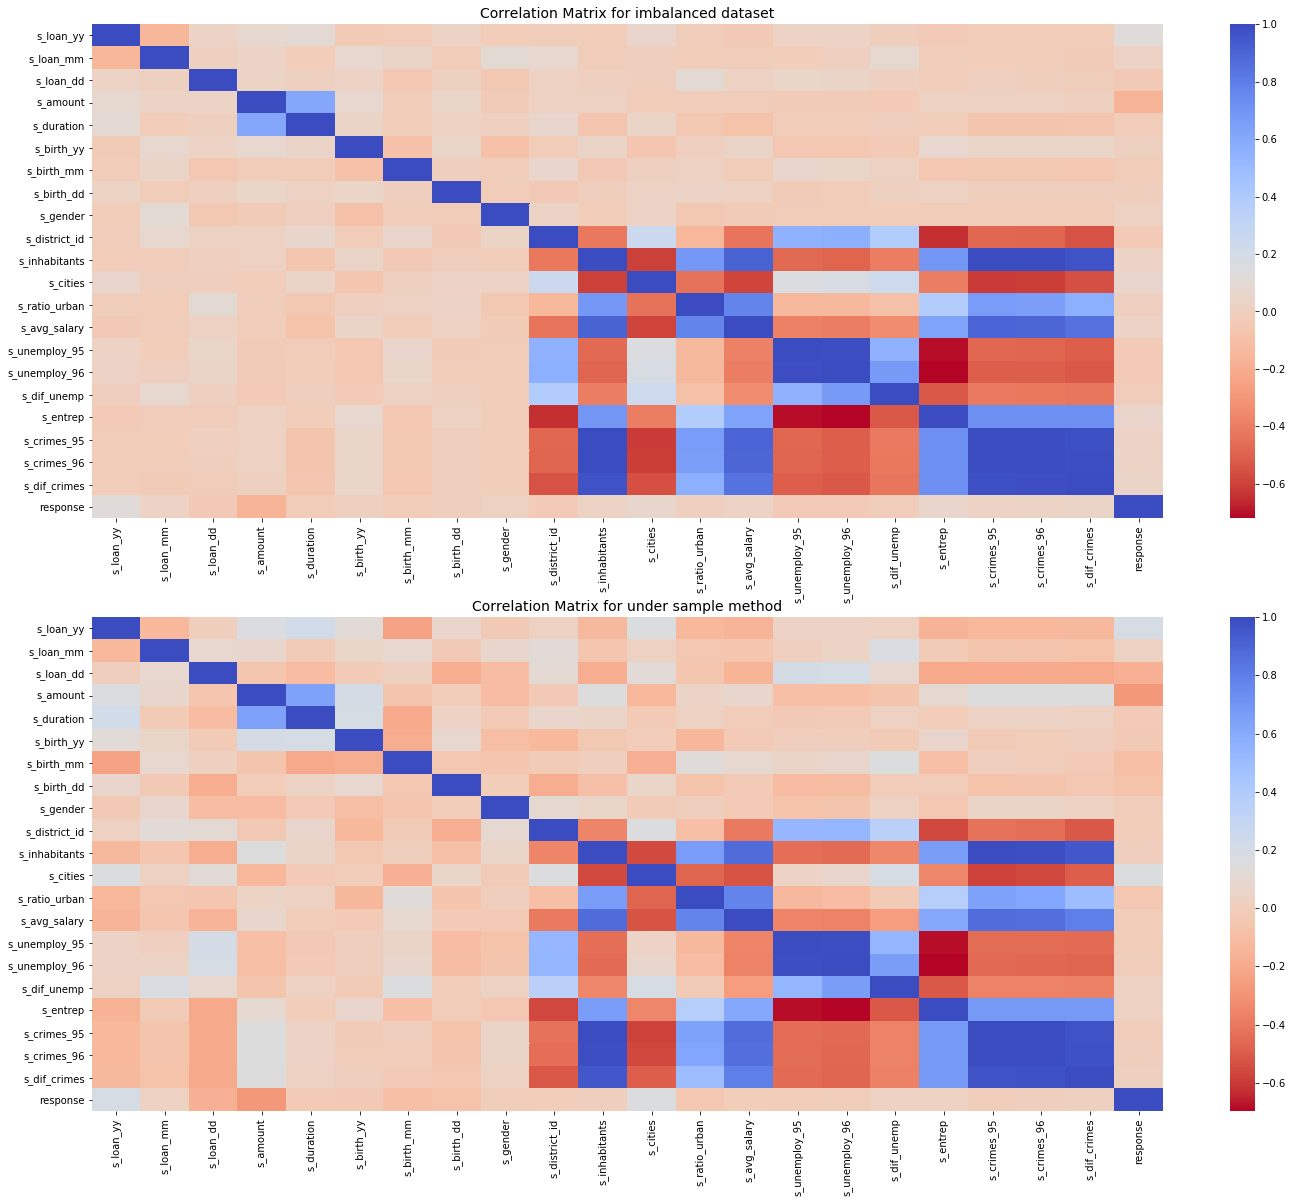

In [42]:
# Correlation Matrix
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))
# For all dataset
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Correlation Matrix for imbalanced dataset", fontsize=14)

# For the balanced under sample dataset
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Correlation Matrix for under sample method', fontsize=14)
plt.show()

In [45]:
# Split test and train from the under sample dataset from dimensionality reduction
X = new_df.drop('response', axis=1)
y = new_df['response']

#Dimensionality Reduction
# T-SNE
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()

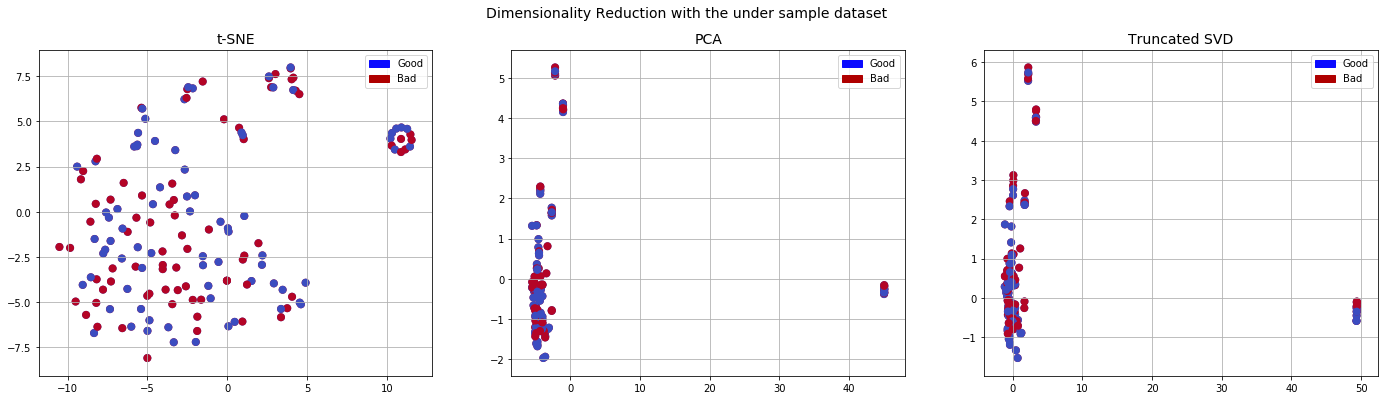

In [46]:
# Dimensionality reduction

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Dimensionality Reduction with the under sample dataset', fontsize=14)
blue_patch = mpatches.Patch(color='#0A0AFF', label='Good')
red_patch = mpatches.Patch(color='#AF0000', label='Bad')

# t-SNE plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Good', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Bad', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Good', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='Bad', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Good', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='Bad', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [47]:
# split train and test data to compare models, even with the lack of correlation
X = new_df.drop('response', axis=1)
y = new_df['response']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Create arrays for the algorithms
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [49]:
# Build models, result change because data shuffle
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [50]:
from sklearn.model_selection import cross_val_score
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Model ", classifier.__class__.__name__, "training score: ", round(training_score.mean(), 2) * 100, "% accuracy")

Model  LogisticRegression training score:  62.0 % accuracy
Model  KNeighborsClassifier training score:  52.0 % accuracy
Model  SVC training score:  50.0 % accuracy
Model  DecisionTreeClassifier training score:  56.00000000000001 % accuracy


In [51]:
# GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

# KNN
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
knears_neighbors = grid_knears.best_estimator_

# SVM
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

# DecisionTree
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

In [52]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('KNN Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('SVM Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  65.3%
KNN Cross Validation Score 52.0%
SVM Cross Validation Score 57.87%
DecisionTree Cross Validation Score 62.0%


In [53]:
# Over sample with SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# Lists for results
#print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
#print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []


In [55]:
# Log classifier with optimal parameters
log_reg_params = {"solver": ['liblinear'], "penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg_sm = LogisticRegression()
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

# Implementing SMOT with cross validation
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)   
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))

accuracy: 0.6483653044203503
precision: 0.9164641869563341
recall: 0.6649484536082475
f1: 0.7703706005281601


In [56]:
labels = ['Good', 'Bad']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

        Good       0.20      0.60      0.31        15
         Bad       0.93      0.71      0.81       121

    accuracy                           0.70       136
   macro avg       0.57      0.66      0.56       136
weighted avg       0.85      0.70      0.75       136



In [57]:
y_score = best_est.decision_function(original_Xtest)
print(y_score)

[ 2.14847915  2.02097817  3.61827863 -2.5793815  -1.4939904  -2.38107137
 -1.47847184  0.46027023  0.88954593  0.1316619   0.66675026 -0.41228158
  0.87116131 -2.41297333  2.72009774 -1.58804358  2.04099434 -0.35929602
 -1.72032628  0.56663958 -0.3438844   0.49330461  0.67056173  1.4261445
  0.49473248  1.79513364  2.5719282   2.74613421  1.37490383 -0.49108868
 -0.11773659  0.85585362  2.10879138  3.22572501  1.69665882  2.57574758
  0.98910079  2.83410531  2.76286178  2.78715491  0.69335515  1.47015355
  2.65778705  0.24382627  0.99884355 -1.37556111  0.9149003   0.63142477
 -0.21737202  1.04953569  3.30449259 -0.71345814 -0.72149026  2.00406339
  1.25388276 -0.21092311 -0.04548852 -1.02884974 -0.25713254 -0.84285503
  0.7227942  -0.64641447  0.36403875 -1.02738773  3.17015811  0.35295392
  1.47973876  1.53591046 -0.08743708  0.78242818  1.45457896  0.71636562
  2.20462805  2.28917796  1.67987619  2.18867157  0.45001229  2.86690042
  3.02763887 -0.48421093  2.56214945  2.01442034  1.

In [58]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(original_ytest, y_score)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.94


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.94')

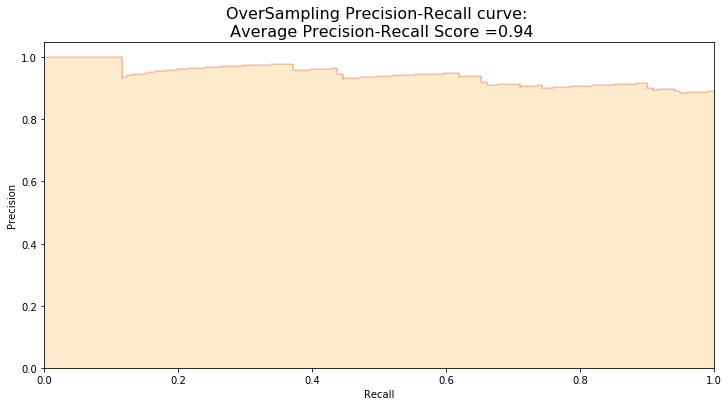

In [48]:
from sklearn.metrics import precision_recall_curve

fig = plt.figure(figsize=(12,6))
precision, recall, _ = precision_recall_curve(original_ytest, y_score)
plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [60]:
# SMOTE Over Sampling after splitting and Cross Validating
sm = SMOTE(sampling_strategy="minority", random_state=42)
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
# Logistic Regression
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)

LogisticRegression(C=10)

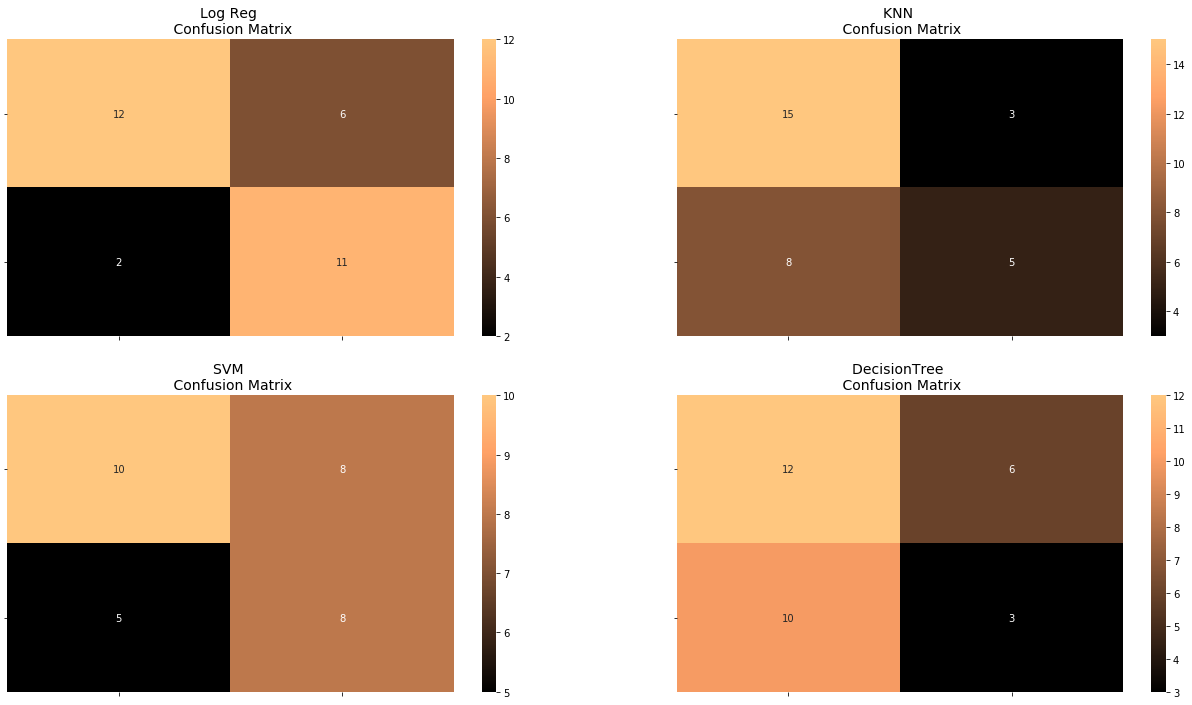

In [61]:
#confusion matrix for each model
from sklearn.metrics import confusion_matrix

y_pred_log_reg = log_reg_sm.predict(X_test)
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)
fig, ax = plt.subplots(2, 2,figsize=(22,12))

sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Log Reg \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNN \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("SVM \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

In [62]:
from sklearn.metrics import classification_report

print('Log Reg:')
print(classification_report(y_test, y_pred_log_reg))
print('KNN:')
print(classification_report(y_test, y_pred_knear))
print('SVM:')
print(classification_report(y_test, y_pred_svc))
print('Decision Tree:')
print(classification_report(y_test, y_pred_tree))

Log Reg:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75        18
           1       0.65      0.85      0.73        13

    accuracy                           0.74        31
   macro avg       0.75      0.76      0.74        31
weighted avg       0.77      0.74      0.74        31

KNN:
              precision    recall  f1-score   support

           0       0.65      0.83      0.73        18
           1       0.62      0.38      0.48        13

    accuracy                           0.65        31
   macro avg       0.64      0.61      0.60        31
weighted avg       0.64      0.65      0.62        31

SVM:
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        18
           1       0.50      0.62      0.55        13

    accuracy                           0.58        31
   macro avg       0.58      0.59      0.58        31
weighted avg       0.60      0.58      0.58        31



In [63]:
# logistic regression accuracy comparison (under / over sampling)
from sklearn.metrics import accuracy_score

y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Alternatives': ['UnderSampling', 'Oversampling'], 'Accuracy': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)
score = final_df['Accuracy']
final_df.drop('Accuracy', axis=1, inplace=True)
final_df.insert(1, 'Accuracy', score)

# could be misleading
final_df

,Alternatives,Accuracy
0,UnderSampling,0.741935
1,Oversampling,0.698529


In [68]:
# Check Correlation in over sample dataset
X_ini = df.drop('response', axis=1)
y_ini = df['response']

counter_y_ini = Counter(y_ini)
print(counter_y_ini)

Counter({1: 606, 0: 76})


In [69]:
oversample = SMOTE()
X_os, y_os = oversample.fit_resample(X_ini, y_ini)

counter_y_os = Counter(y_os)
print(counter_y_os)


Counter({1: 606, 0: 606})


In [70]:
#adding response to over sample dataset
os_df= X_os
os_df.insert(21, 'response', y_os)
os_df.head()

,s_loan_yy,s_loan_mm,s_loan_dd,s_amount,s_duration,s_birth_yy,s_birth_mm,s_birth_dd,s_gender,s_district_id,...,s_ratio_urban,s_avg_salary,s_unemploy_95,s_unemploy_96,s_dif_unemp,s_entrep,s_crimes_95,s_crimes_96,s_dif_crimes,response
0,-1.5,-0.500000,0.1875,-0.359528,-1.0,-0.045455,0.296296,0.8125,1.0,-0.804348,...,-0.605970,0.000000,-0.348548,-0.452297,-0.571429,-0.153846,-0.187852,-0.207953,-0.311874,1
1,0.0,0.833333,-0.2500,0.269813,-0.5,-0.454545,0.000000,0.9375,0.0,-0.152174,...,0.677612,-0.203252,1.228216,1.455830,2.285714,0.038462,0.222947,0.299770,0.317597,1
2,-1.0,-0.166667,-0.1250,0.157085,-0.5,-0.772727,0.296296,-0.1875,0.0,0.456522,...,-0.244776,-0.122690,0.817427,0.795053,0.714286,-0.307692,-0.348031,-0.395062,-0.432046,1
3,0.0,0.166667,-0.3125,1.276191,1.0,0.272727,-0.148148,0.6250,0.0,-0.282609,...,-0.543284,-0.309682,-0.887967,-0.777385,0.107143,-0.192308,-0.591676,-0.626342,0.000000,1
4,-1.0,0.666667,0.1875,0.452412,1.0,-0.318182,-0.592593,0.5000,0.0,-0.456522,...,-0.277612,-0.427199,0.141079,0.173145,0.482143,0.192308,-0.598425,-0.633290,0.005722,1


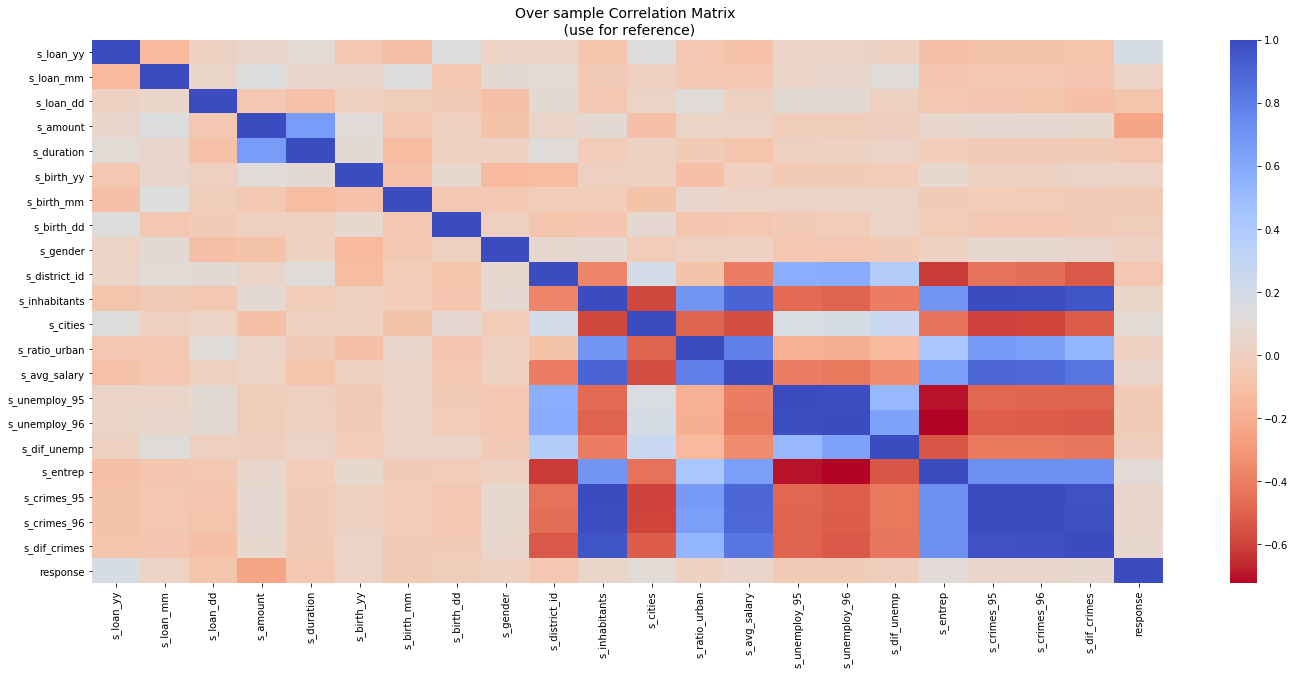

In [71]:
# Correlation Matrix for over sample dataset
f, (ax2) = plt.subplots(1, 1, figsize=(24,10))
over_sample_corr = os_df.corr()
sns.heatmap(over_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Over sample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()